# Satellites from Riley 2019
## MSP, 17.4.2019



In [1]:
# standard python modules
import numpy as np
import time
import copy



# plotting utilities
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

cmap = mpl.cm.inferno


import scipy.interpolate as interpolate


import subprocess



In [2]:
# exptool imports
from exptool.basis import eof
from exptool.basis import spheresl
from exptool.basis import *

#from exptool.basis import spheresl_new


from ssl import *
from exptool.io import psp_io

from exptool.analysis import pattern
from exptool.analysis import trapping

import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

from exptool.utils import *


stylepar='medium'

if stylepar == 'medium':
    mpl.rcParams['font.weight'] = 'medium'
    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.75
    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['ytick.minor.width'] = 0.75
    mpl.rcParams['ytick.minor.visible'] = True







In [3]:
# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u


# print to a file...

# with a flipped vb ONLY?


def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    #dL=np.arctan(y0/x0)/f
    
    #dL[(y0<0)&(x0>0.)] += 360.
    #dL[(y0>0)&(x0<0.)] += 180.
    #dL[(y0<0)&(x0<0.)] += 180.
    
    dL = np.arctan2(y0,x0)/f
    
    #print(dL)
    
    if dL.size>1:
        dL[np.array(dL)<0.] += 360.
    else:
        if dL<0.: dL+=360.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub


In [4]:
# now we need to reconstruct some stuff...
#    Satellite & RA & Dec & $M_V$ & $d_\odot$ & $v_\odot$ & $\mu_{\alpha^\ast}^\text{F18}$ & $\mu_{\delta}^\text{F18}$ & $\mu_{\alpha^\ast}^\text{gold}$ & $\mu_{\delta}^\text{gold}$ & PM$_\text{gold}$ & Refs. \\
#    & [deg] & [deg] & [mag] & \Ref{[kpc]} & [km~s$^{-1}$] & [mas yr$^{-1}$] & [mas yr$^{-1}$] & [mas yr$^{-1}$] & [mas yr$^{-1}$] &  &  \\
#    \hline
f = open('data/RileySatsObs.txt')

nsats = 36
Satellites = {}
Satellites['name'] = np.zeros(nsats,dtype='S20')
Satellites['ra'] = np.zeros(nsats)
Satellites['dec'] = np.zeros(nsats)
Satellites['dist'] = np.zeros(nsats)
Satellites['edist'] = np.zeros(nsats)
Satellites['vlos'] = np.zeros(nsats)
Satellites['evlos'] = np.zeros(nsats)
Satellites['pmracosdec'] = np.zeros(nsats)
Satellites['epmracosdec'] = np.zeros(nsats)
Satellites['pmdec'] = np.zeros(nsats)
Satellites['epmdec'] = np.zeros(nsats)

# there is also a 'gold sample' of pm values that we can use

i = 0
for line in f:
    satname = line.split('&')[0].strip()
    if (satname!='LMC') & (satname!='SMC'): 
        satnamenew = ''
        for x in satname:
            if x!= ' ':
                satnamenew+=x
        Satellites['name'][i] = satnamenew
        Satellites['ra'][i] = float(line.split('&')[1].strip())
        Satellites['dec'][i] = float(line.split('&')[2].strip())
        Satellites['dist'][i] = float((line.split('&')[4]).split('\pm')[0].lstrip(' $'))
        Satellites['edist'][i] = float((line.split('&')[4]).split('\pm')[1].rstrip(' $'))
        Satellites['vlos'][i] = float((line.split('&')[5]).split('\pm')[0].lstrip(' $'))
        Satellites['evlos'][i] = float((line.split('&')[5]).split('\pm')[1].rstrip(' $'))
        Satellites['pmracosdec'][i] = float((line.split('&')[6]).split('\pm')[0].lstrip(' $'))
        Satellites['epmracosdec'][i] = float((line.split('&')[6]).split('\pm')[1].rstrip(' $'))
        Satellites['pmdec'][i] = float((line.split('&')[7]).split('\pm')[0].lstrip(' $'))
        Satellites['epmdec'][i] = float((line.split('&')[7]).split('\pm')[1].rstrip(' $'))
        #print(line.split('&')[0].strip())
        i+=1
    
print('nsats',i)

print(Satellites['name'])
f.close()

nsats 36
[b'AquariusII' b'BootesI' b'BootesII' b'CanesVenaticiI' b'CanesVenaticiII'
 b'CarinaI' b'CarinaII' b'CarinaIII' b'ComaBerenicesI' b'CraterII'
 b'DracoI' b'DracoII' b'Fornax' b'GrusI' b'Hercules' b'HorologiumI'
 b'HydraII' b'HydrusI' b'LeoI' b'LeoII' b'LeoIV' b'LeoV' b'PiscesII'
 b'ReticulumII' b'SagittariusI' b'Sculptor' b'Segue1' b'Segue2' b'Sextans'
 b'TriangulumII' b'TucanaII' b'TucanaIII' b'UrsaMajorI' b'UrsaMajorII'
 b'UrsaMinor' b'Willman1']


In [5]:
# now we need to reconstruct some stuff...
#    Satellite & RA & Dec & $M_V$ & $d_\odot$ & $v_\odot$ & $\mu_{\alpha^\ast}^\text{F18}$ & $\mu_{\delta}^\text{F18}$ & $\mu_{\alpha^\ast}^\text{gold}$ & $\mu_{\delta}^\text{gold}$ & PM$_\text{gold}$ & Refs. \\
#    & [deg] & [deg] & [mag] & \Ref{[kpc]} & [km~s$^{-1}$] & [mas yr$^{-1}$] & [mas yr$^{-1}$] & [mas yr$^{-1}$] & [mas yr$^{-1}$] &  &  \\
#    \hline
f = open('data/RileySatsObs.txt')

nsats = 38+8
Satellites = {}
Satellites['name'] = np.zeros(nsats,dtype='S20')
Satellites['ra'] = np.zeros(nsats)
Satellites['dec'] = np.zeros(nsats)
Satellites['dist'] = np.zeros(nsats)
Satellites['edist'] = np.zeros(nsats)
Satellites['vlos'] = np.zeros(nsats)
Satellites['evlos'] = np.zeros(nsats)
Satellites['pmracosdec'] = np.zeros(nsats)
Satellites['epmracosdec'] = np.zeros(nsats)
Satellites['pmdec'] = np.zeros(nsats)
Satellites['epmdec'] = np.zeros(nsats)

# there is also a 'gold sample' of pm values that we can use

i = 0
for line in f:
    satname = line.split('&')[0].strip()
    if (satname!='blahblah'): 
        satnamenew = ''
        for x in satname:
            if x!= ' ':
                satnamenew+=x
        Satellites['name'][i] = satnamenew
        Satellites['ra'][i] = float(line.split('&')[1].strip())
        Satellites['dec'][i] = float(line.split('&')[2].strip())
        Satellites['dist'][i] = float((line.split('&')[4]).split('\pm')[0].lstrip(' $'))
        Satellites['edist'][i] = float((line.split('&')[4]).split('\pm')[1].rstrip(' $'))
        Satellites['vlos'][i] = float((line.split('&')[5]).split('\pm')[0].lstrip(' $'))
        Satellites['evlos'][i] = float((line.split('&')[5]).split('\pm')[1].rstrip(' $'))
        Satellites['pmracosdec'][i] = float((line.split('&')[6]).split('\pm')[0].lstrip(' $'))
        Satellites['epmracosdec'][i] = float((line.split('&')[6]).split('\pm')[1].rstrip(' $'))
        Satellites['pmdec'][i] = float((line.split('&')[7]).split('\pm')[0].lstrip(' $'))
        Satellites['epmdec'][i] = float((line.split('&')[7]).split('\pm')[1].rstrip(' $'))
        #print(line.split('&')[0].strip())
        i+=1
    
print('nsats',i)

print(Satellites['name'])
f.close()

nsats 38
[b'AquariusII' b'BootesI' b'BootesII' b'CanesVenaticiI' b'CanesVenaticiII'
 b'CarinaI' b'CarinaII' b'CarinaIII' b'ComaBerenicesI' b'CraterII'
 b'DracoI' b'DracoII' b'Fornax' b'GrusI' b'Hercules' b'HorologiumI'
 b'HydraII' b'HydrusI' b'LeoI' b'LeoII' b'LeoIV' b'LeoV' b'LMC'
 b'PiscesII' b'ReticulumII' b'SagittariusI' b'Sculptor' b'Segue1'
 b'Segue2' b'Sextans' b'SMC' b'TriangulumII' b'TucanaII' b'TucanaIII'
 b'UrsaMajorI' b'UrsaMajorII' b'UrsaMinor' b'Willman1' b'' b'' b'' b'' b''
 b'' b'' b'']


In [6]:
# add some extra satellites in by hand...

Satellites['name'][i] = 'Antlia2' # torrealba 2019b
Satellites['ra'][i] = 143.89
Satellites['dec'][i] = -36.77
Satellites['dist'][i] = 132.00
Satellites['edist'][i] = 10.
Satellites['vlos'][i] = 290.9
Satellites['evlos'][i] = 0.5
Satellites['pmracosdec'][i] = -0.095
Satellites['epmracosdec'][i] = 0.03
Satellites['pmdec'][i] = 0.058
Satellites['epmdec'][i] = 0.04
i+=1
    
Satellites['name'][i] = 'EridanusII' # pace&li
Satellites['ra'][i] = 56.0838
Satellites['dec'][i] = -43.5338
Satellites['dist'][i] = 366
Satellites['edist'][i] = 36.6
Satellites['vlos'][i] = 75.6 # li,t. simon,j. 2017
Satellites['evlos'][i] = 2.3
Satellites['pmracosdec'][i] = 0.16
Satellites['epmracosdec'][i] = 0.24
Satellites['pmdec'][i] = 0.15
Satellites['epmdec'][i] = 0.26
i+=1
    
Satellites['name'][i] = 'ColumbaI' # pace&li
Satellites['ra'][i] = 82.8570
Satellites['dec'][i] = -28.0425
Satellites['dist'][i] = 183
Satellites['edist'][i] = 18.3
Satellites['vlos'][i] = 153.7 # fritz2019
Satellites['evlos'][i] = 5.0
Satellites['pmracosdec'][i] = -0.02
Satellites['epmracosdec'][i] = 0.25
Satellites['pmdec'][i] = -0.04
Satellites['epmdec'][i] = 0.3
i+=1
    

Satellites['name'][i] = 'GrusII' # pace&li
Satellites['ra'][i] = 331.0200
Satellites['dec'][i] = -46.4400
Satellites['dist'][i] = 53
Satellites['edist'][i] = 5.3
Satellites['vlos'][i] = -110. # simon 2019
Satellites['evlos'][i] = 0.5
Satellites['pmracosdec'][i] = 0.43
Satellites['epmracosdec'][i] = 0.09
Satellites['pmdec'][i] = -1.45
Satellites['epmdec'][i] = 0.13
i+=1


Satellites['name'][i] = 'PhoenixII' # pace&li
Satellites['ra'][i] = 354.9975
Satellites['dec'][i] = -54.4060
Satellites['dist'][i] = 84.3
Satellites['edist'][i] = 8.43
Satellites['vlos'][i] = 32.4 # fritz2019
Satellites['evlos'][i] = 3.8
Satellites['pmracosdec'][i] = 0.49
Satellites['epmracosdec'][i] = 0.11
Satellites['pmdec'][i] = -1.03
Satellites['epmdec'][i] = 0.12
i+=1

Satellites['name'][i] = 'ReticulumIII' # pace&li
Satellites['ra'][i] = 56.3600
Satellites['dec'][i] = -60.4500
Satellites['dist'][i] = 92
Satellites['edist'][i] = 9.2
Satellites['vlos'][i] = 274.2 # fritz2019
Satellites['evlos'][i] = 7.5
Satellites['pmracosdec'][i] = -1.02
Satellites['epmracosdec'][i] = 0.3
Satellites['pmdec'][i] = -1.23
Satellites['epmdec'][i] = 0.38
i+=1


Satellites['name'][i] = 'TucanaIV' # pace&li
Satellites['ra'][i] = 0.7300
Satellites['dec'][i] = -60.8500
Satellites['dist'][i] = 48
Satellites['edist'][i] = 4.8
Satellites['vlos'][i] = 15.9 # simon 2019
Satellites['evlos'][i] = 1.8
Satellites['pmracosdec'][i] = 0.63
Satellites['epmracosdec'][i] = 0.23
Satellites['pmdec'][i] = -1.71
Satellites['epmdec'][i] = 0.24
i+=1

Satellites['name'][i] = 'TucanaV' # simon 2019
Satellites['ra'][i] = 354.35
Satellites['dec'][i] = -63.27
Satellites['dist'][i] = 55.21
Satellites['edist'][i] = 5.5
Satellites['vlos'][i] = -36.2 # simon 2019
Satellites['evlos'][i] = 2.5
Satellites['pmracosdec'][i] = -0.62
Satellites['epmracosdec'][i] = 0.31
Satellites['pmdec'][i] = -0.88
Satellites['epmdec'][i] = 0.35
i+=1




In [7]:
satsort = satdist.argsort()
plt.plot(satdist[satsort])
satrange = np.linspace(0,1.,satsort.size)

f = open('processed/satdist.txt','w')
for indx in range(0,satsort.size):
    print(satdist[satsort[indx]],satrange[indx],file=f)
    
f.close()

NameError: name 'satdist' is not defined

In [8]:
# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)




def find_errors(Satellites,indx,nsamples=10000,verbose=False):
    ra = Satellites['ra'][indx]
    dec = Satellites['dec'][indx]
    
    d = Satellites['dist'][indx]
    derr = Satellites['edist'][indx]
    pmra = Satellites['pmracosdec'][indx]
    pmraerr = Satellites['epmracosdec'][indx]
    pmdec = Satellites['pmdec'][indx]
    pmdecerr = Satellites['epmdec'][indx]
    
    vrad = Satellites['vlos'][indx]
    vraderr = Satellites['evlos'][indx]

    cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                           dec             = np.tile(dec,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(d     + np.random.normal(size=nsamples)*derr)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                           pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                           radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                           dec             = dec   * u.deg,\
                           distance        = d     * u.kpc,\
                           pm_ra_cosdec    = pmra  * u.mas/u.yr,\
                           pm_dec          = pmdec * u.mas/u.yr,\
                           radial_velocity = vrad  * u.km/u.s)

    if verbose:
        print(pmra,pmdec,vrad)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    return gal_latlon,gal_defined,best_latlon,best_defined


indx = 30
gal_latlon,gal_defined,best_latlon,best_defined = find_errors(Satellites,indx,nsamples=1000,verbose=True)

0.797 -1.22 145.6


In [9]:

g = open('processed/satellites_updated_cartesian_heliocentric.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];\
      name;',file=g)




for indx,i in enumerate(np.arange(0,Satellites['name'].size,1)):

    gal_latlon,gal_defined,best_latlon,best_defined = find_errors(Satellites,indx,nsamples=1000)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):


        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              Satellites['name'][indx].decode(),\
              file=g)


g.close()











In [146]:
In2 = np.genfromtxt('processed/satellites_updated_cartesian_heliocentric.txt',skip_header=1,dtype='S20')

name = In2[:,16]
print(name)


[b'Aquarius2' b'Bootes1' b'Bootes2' b'CanesVenatici1' b'CanesVenatici2'
 b'Carina' b'Carina2' b'Carina3' b'ComaBerenices' b'Crater2' b'Draco'
 b'Draco2' b'Fornax' b'Grus1' b'Hercules' b'Horologium1' b'Hydra2'
 b'Hydrus1' b'Leo1' b'Leo2' b'Leo4' b'Leo5' b'LMC' b'Pisces2'
 b'Reticulum2' b'Sagittarius1' b'Sculptor' b'Segue1' b'Segue2' b'Sextans1'
 b'SMC' b'Triangulum2' b'Tucana2' b'Tucana3' b'UrsaMajor1' b'UrsaMajor2'
 b'UrsaMinor' b'Willman1' b'Antlia2' b'Eridanus2' b'Columba1' b'Grus2'
 b'Phoenix2' b'Reticulum3' b'Tucana4' b'Tucana5']


In [148]:
print(name)

[b'Aquarius2' b'Bootes1' b'Bootes2' b'CanesVenatici1' b'CanesVenatici2'
 b'Carina' b'Carina2' b'Carina3' b'ComaBerenices' b'Crater2' b'Draco'
 b'Draco2' b'Fornax' b'Grus1' b'Hercules' b'Horologium1' b'Hydra2'
 b'Hydrus1' b'Leo1' b'Leo2' b'Leo4' b'Leo5' b'LMC' b'Pisces2'
 b'Reticulum2' b'Sagittarius1' b'Sculptor' b'Segue1' b'Segue2' b'Sextans1'
 b'SMC' b'Triangulum2' b'Tucana2' b'Tucana3' b'UrsaMajor1' b'UrsaMajor2'
 b'UrsaMinor' b'Willman1' b'Antlia2' b'Eridanus2' b'Columba1' b'Grus2'
 b'Phoenix2' b'Reticulum3' b'Tucana4' b'Tucana5']


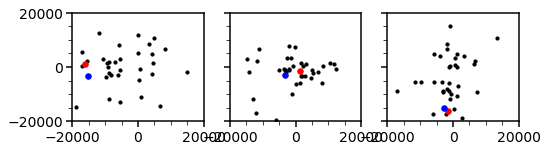

In [149]:
lmcx = -0.62
lmcvx = -39.47
lmcy = -42.11
lmcvy = -229.29
lmcz = -27.69
lmcvz = 230.24
lmcmom = [np.round(lmcy*lmcvz - lmcz*lmcvy),np.round(lmcz*lmcvx - lmcx*lmcvz),np.round(lmcx*lmcvy - lmcy*lmcvx)]


    
smcx = 16.35
smcvx = 7.77
smcy = -38.5
smcvy = -191.2 
smcz = -44.76
smcvz = 171.71
smcmom = [np.round(smcy*smcvz - smcz*smcvy),np.round(smcz*smcvx - smcx*smcvz),np.round(smcx*smcvy - smcy*smcvx)]




def compute_momentum(x,y,z,vx,vy,vz):
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)
    return Lx,Ly,Lz


Lx,Ly,Lz = compute_momentum(x,y,z,vx,vy,vz)

fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)




ax1.scatter(Lx,Ly,color='black',s=10.)
ax2.scatter(Ly,Lz,color='black',s=10.)
ax3.scatter(Lz,Lx,color='black',s=10.)

ax1.scatter(lmcmom[0],lmcmom[1],color='red',s=30.)
ax2.scatter(lmcmom[1],lmcmom[2],color='red',s=30.)
ax3.scatter(lmcmom[2],lmcmom[0],color='red',s=30.)


ax1.scatter(smcmom[0],smcmom[1],color='blue',s=30.)
ax2.scatter(smcmom[1],smcmom[2],color='blue',s=30.)
ax3.scatter(smcmom[2],smcmom[0],color='blue',s=30.)




for ax in [ax1,ax2,ax3]:
    ax.axis([-20000,20000,-20000,20000])

for ax in [ax2,ax3]:
    ax.set_yticklabels(())

In [150]:
print(lmcmom)

mcmomdiff = np.sqrt((smcmom[0]-lmcmom[0])**2. + (smcmom[1]-lmcmom[1])**2. + (smcmom[2]-lmcmom[2])**2.)

print(mcmomdiff)
print(smcmom)


[-16044.0, 1236.0, -1520.0]
4664.199288195135
[-15169.0, -3155.0, -2827.0]


array([b'LMC', b'Horologium1', b'Carina', b'SMC', b'Phoenix2', b'Carina3',
       b'Draco', b'Hydrus1', b'UrsaMinor', b'Tucana4', b'Crater2',
       b'Reticulum2', b'Grus2', b'Draco2', b'Carina2', b'Fornax', b'Leo2',
       b'Tucana2', b'Antlia2', b'Willman1'], dtype='|S20')

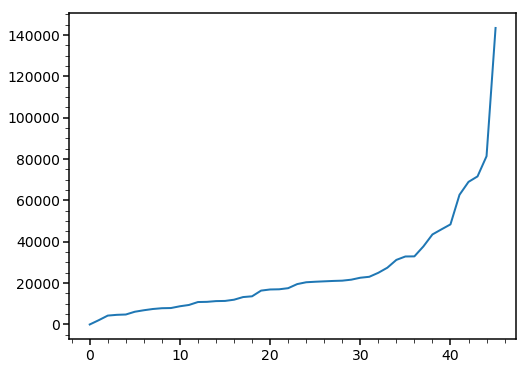

In [151]:
angmomdiffo = np.sqrt((Lx-lmcmom[0])**2. + (Ly-lmcmom[1])**2. + (Lz-lmcmom[2])**2.)

plt.plot(angmomdiffo[angmomdiffo.argsort()])

name[angmomdiffo.argsort()][0:20]

## Test McConnachie & Kim 2020 results

In [85]:

f = open('data/mcconnachie20_vrad.txt')

header = f.readline().split('&')
print(header)
#f.readline()

# generally, we will need to 
# split on &
# remove \ and spaces
linein = f.readline()

McSats = {}


McSats['name'] = []
McSats['ra'] = []
McSats['dec'] = []
McSats['vhel'] = []
McSats['vhell'] = []
McSats['vhelh'] = []
McSats['dmod'] = []
McSats['dmodl'] = []
McSats['dmodh'] = []

nsats = 0
while linein != '': # will read until a blank line or EOF
    nsats += 1
    line = linein.split('&')
    
    name = line[0].split('\\')[0].strip(' ')

    if line[7].strip() == '---':
        print('skipping',name)#,line)
        linein = f.readline()
        nsats -= 1
        continue
        
    if name == '{':
        print('skipping',line[0])
        linein = f.readline()
        nsats -= 1
        continue
    
    McSats['name'].append(name)
    
    McSats['ra'].append(float(line[1]))
    McSats['dec'].append(float(line[2]))

    dmodfull = line[3]
    
    if '^' in dmodfull:
        McSats['dmod'].append(float(dmodfull.split('^')[0].strip(' $')))
        McSats['dmodh'].append(float(dmodfull.split('^')[1].split('_')[0].strip(' $}{')))
        McSats['dmodl'].append(float(dmodfull.split('^')[1].split('_')[1].strip(' $}{')))
    else:
        McSats['dmod'].append(float(dmodfull.split('\\pm')[0].strip(' $')))
        McSats['dmodh'].append(float(dmodfull.split('\\pm')[1].strip(' $')))
        McSats['dmodl'].append(float(dmodfull.split('\\pm')[1].strip(' $')))

    

    vhelfull = line[7]
    
    if '^' in vhelfull:
        McSats['vhel'].append(float(vhelfull.split('^')[0].strip(' $')))
        McSats['vhelh'].append(float(vhelfull.split('^')[1].split('_')[0].strip(' $}{')))
        McSats['vhell'].append(float(vhelfull.split('^')[1].split('_')[1].strip(' $}{')))
    else:
        McSats['vhel'].append(float(vhelfull.split('\\pm')[0].strip(' $')))
        McSats['vhelh'].append(float(vhelfull.split('\\pm')[1].strip(' $')))
        McSats['vhell'].append(float(vhelfull.split('\\pm')[1].strip(' $')))

    
    #print(name,mualpha)
    linein = f.readline()

print('Found {} satellites.'.format(nsats))

for key in McSats.keys():
    McSats[key] = np.array(McSats[key])

print(McSats['name'])

['Galaxy ', ' RA (degs) ', ' Dec (degs) ', ' $(m - M)_0$ ', ' $r_h$ (arcmins)', ' $e = 1 - b/a$ ', ' $\\theta ^\\circ$ ', ' $v_h$ (km\\,s$^{-1}$)', '$\\sigma_v$ (km\\,s$^{-1}$) ', ' $<$[Fe/H]$>$\\\\\n']
skipping {
skipping Centaurus1
skipping Cetus2
skipping {
skipping DESJ0225+0304
skipping Eridanus3
skipping Indus1
skipping {
skipping {\it Pegasus3}        
skipping Pictor2
skipping Pictoris1
skipping {
Found 47 satellites.
['Antlia2' 'Aquarius2' 'Bootes1' 'Bootes2' 'CanesVenatici1'
 'CanesVenatici2' 'Carina' 'Carina2' 'Carina3' 'Columba1' 'ComaBerenices'
 'Crater2' 'Draco' 'Draco2' 'Eridanus2' 'Fornax' 'Grus1' 'Grus2'
 'Hercules' 'Horologium1' 'Horologium2' 'Hydra2' 'Hydrus1' 'Leo1' 'Leo2'
 'Leo4' 'Leo5' 'LeoT' 'Phoenix' 'Phoenix2' 'Pisces2' 'Reticulum2'
 'Reticulum3' 'Sagittarius2' 'Sculptor' 'Segue1' 'Segue2' 'Sextans1'
 'Triangulum2' 'Tucana2' 'Tucana3' 'Tucana4' 'Tucana5' 'UrsaMajor1'
 'UrsaMajor2' 'UrsaMinor' 'Willman1']


In [86]:

f = open('data/mcconnachie20.txt')

header = f.readline().split('&')
print(header)
#f.readline()

# generally, we will need to 
# split on &
# remove \ and spaces
linein = f.readline()

McSats['name2'] = []
McSats['mualpha'] = []
McSats['mualphal'] = []
McSats['mualphah'] = []
McSats['mudelta'] = []
McSats['mudeltal'] = []
McSats['mudeltah'] = []


nsats = 0
while linein != '': # will read until a blank line or EOF
    nsats += 1
    line = linein.split('&')
    name = line[0].split('\\')[0].strip(' ')
    if name not in McSats['name']: 
        print('no radial velocity for',name)
        nsats -= 1
        linein = f.readline()
        continue
    
    McSats['name2'].append(name)


    mualphafull = line[1]
    
    # drop into mualpha loop
    if '^' in mualphafull:
        McSats['mualpha'].append(float(mualphafull.split('^')[0].strip(' $')))
        McSats['mualphah'].append(float(mualphafull.split('^')[1].split('_')[0].strip(' $}{')))
        McSats['mualphal'].append(float(mualphafull.split('^')[1].split('_')[1].strip(' $}{')))
    else:
        McSats['mualpha'].append(float(mualphafull.split('\\pm')[0].strip(' $')))
        McSats['mualphah'].append(float(mualphafull.split('\\pm')[1].strip(' $')))
        McSats['mualphal'].append(float(mualphafull.split('\\pm')[1].strip(' $')))

    mudeltafull = line[2]
    
    # drop into mualpha loop
    if '^' in mudeltafull:
        McSats['mudelta'].append(float(mudeltafull.split('^')[0].strip(' $')))
        McSats['mudeltah'].append(float(mudeltafull.split('^')[1].split('_')[0].strip(' $}{\\')))
        McSats['mudeltal'].append(float(mudeltafull.split('^')[1].split('_')[1].strip(' $}{\\')))
    else:
        McSats['mudelta'].append(float(mudeltafull.split('\\pm')[0].strip(' $')))
        McSats['mudeltah'].append(float(mudeltafull.split('\\pm')[1].strip(' $\\')))
        McSats['mudeltal'].append(float(mudeltafull.split('\\pm')[1].strip(' $\\')))


    
    #print(name,mualpha)
    linein = f.readline()

print('Found {} satellites.'.format(nsats))

for key in McSats.keys():
    McSats[key] = np.array(McSats[key])

print(McSats['mualphal'])

['Galaxy ', '$\\mu_\\alpha\\cos\\delta$ (mas/yr)', '$\\mu_\\delta$ (mas/yr)', ' $v_\\alpha\\cos\\delta$ (km\\,s$^{-1}$) ', ' $v_\\delta$ (km\\,s$^{-1}$)', ' $v_t$ (km\\,s$^{-1}$)', ' $v_r$ (km\\,s$^{-1}$)\\\\\n']
no radial velocity for Centaurus1
no radial velocity for Cetus2
no radial velocity for DESJ0225+0304
no radial velocity for Eridanus3
no radial velocity for Indus1
no radial velocity for Pictor2
no radial velocity for Pictoris1
Found 47 satellites.
[ 0.04   0.16   0.04   0.21   0.05   0.11   0.01   0.03   0.08   0.09
  0.05   0.04   0.01   0.17   0.05   0.002  0.12   0.06   0.07   0.05
 -0.23   0.13   0.03   0.07   0.06   0.13  -0.11   0.05   0.05  -0.07
  0.11   0.03   0.21   0.07   0.005 -0.22  -0.13   0.02  -0.15   0.05
  0.03  -0.12  -0.2    0.06   0.05   0.01   0.1  ]


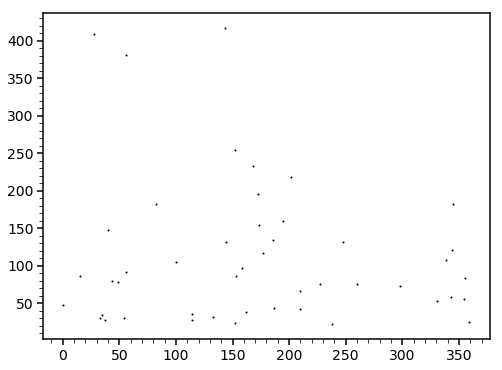

In [88]:

dval = 10.**((McSats['dmod'] + 5.)/5.)/1000.

plt.scatter(McSats['ra'],dval,color='black',s=1.)


In [91]:
np.nanmax([np.abs(McSats['dmodl']),np.abs(McSats['dmodh'])],axis=0)

array([0.11, 0.07, 0.08, 0.06, 0.1 , 0.06, 0.13, 0.05, 0.1 , 0.22, 0.2 ,
       0.02, 0.17, 0.05, 0.2 , 0.18, 0.2 , 0.21, 0.2 , 0.2 , 0.2 , 0.16,
       0.04, 0.13, 0.13, 0.09, 0.16, 0.1 , 0.12, 0.2 , 0.17, 0.2 , 0.31,
       0.03, 0.14, 0.2 , 0.1 , 0.1 , 0.1 , 0.2 , 0.16, 0.19, 0.34, 0.1 ,
       0.3 , 0.1 , 0.4 ])

In [106]:
# put in format for sampling

McSatellites = {}
McSatellites['ra'] = McSats['ra']
McSatellites['name'] = McSats['name']


McSatellites['dec'] = McSats['dec']
McSatellites['dist'] = 10.**((McSats['dmod'] + 5.)/5.)/1000.
McSatellites['edist'] = np.abs((10.**((McSats['dmod']+np.nanmax([McSats['dmodh'],McSats['dmodl']],axis=0) + 5.)/5.)/1000.)-(10.**((McSats['dmod'] + 5.)/5.)/1000.))

McSatellites['pmracosdec'] = McSats['mualpha']
McSatellites['epmracosdec'] = np.nanmax([McSats['mualphah'],McSats['mualphal']],axis=0)

McSatellites['pmdec'] = McSats['mudelta']
McSatellites['epmdec'] = np.nanmax([McSats['mudeltah'],McSats['mudeltal']],axis=0)

McSatellites['vlos'] = McSats['vhel']
McSatellites['evlos'] = np.nanmax([McSats['vhelh'],McSats['vhell']],axis=0)




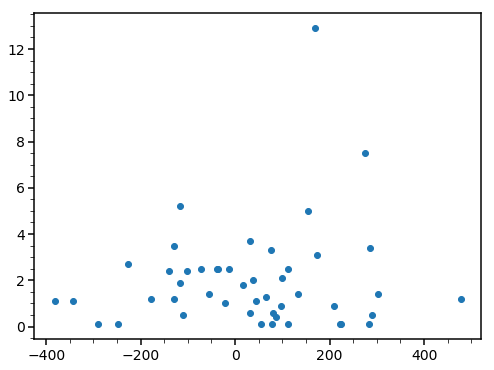

In [107]:
plt.scatter(McSatellites['vlos'],McSatellites['evlos'])

In [109]:

g = open('processed/satellites_mcconnachie.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];\
      name;',file=g)




for indx,i in enumerate(np.arange(0,Satellites['name'].size,1)):

    gal_latlon,gal_defined,best_latlon,best_defined = find_errors(McSatellites,indx,nsamples=1000)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):


        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              McSatellites['name'][indx],\
              file=g)


g.close()












[b'Antlia2' b'Aquarius2' b'Bootes1' b'Bootes2' b'CanesVenatici1'
 b'CanesVenatici2' b'Carina' b'Carina2' b'Carina3' b'Columba1'
 b'ComaBerenices' b'Crater2' b'Draco' b'Draco2' b'Eridanus2' b'Fornax'
 b'Grus1' b'Grus2' b'Hercules' b'Horologium1' b'Horologium2' b'Hydra2'
 b'Hydrus1' b'Leo1' b'Leo2' b'Leo4' b'Leo5' b'LeoT' b'Phoenix' b'Phoenix2'
 b'Pisces2' b'Reticulum2' b'Reticulum3' b'Sagittarius2' b'Sculptor'
 b'Segue1' b'Segue2' b'Sextans1' b'Triangulum2' b'Tucana2' b'Tucana3'
 b'Tucana4' b'Tucana5' b'UrsaMajor1' b'UrsaMajor2' b'UrsaMinor']
[b'Aquarius2' b'Bootes1' b'Bootes2' b'CanesVenatici1' b'CanesVenatici2'
 b'Carina' b'Carina2' b'Carina3' b'ComaBerenices' b'Crater2' b'Draco'
 b'Draco2' b'Fornax' b'Grus1' b'Hercules' b'Horologium1' b'Hydra2'
 b'Hydrus1' b'Leo1' b'Leo2' b'Leo4' b'Leo5' b'LMC' b'Pisces2'
 b'Reticulum2' b'Sagittarius1' b'Sculptor' b'Segue1' b'Segue2' b'Sextans1'
 b'SMC' b'Triangulum2' b'Tucana2' b'Tucana3' b'UrsaMajor1' b'UrsaMajor2'
 b'UrsaMinor' b'Willman1' b'Antli

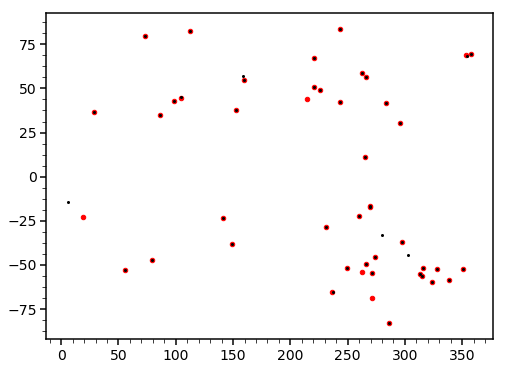

In [158]:
In2 = np.genfromtxt('processed/satellites_mcconnachie.txt',skip_header=1,dtype='S20')

name = In2[:,16]
print(name)


In = np.genfromtxt('processed/satellites_mcconnachie.txt',skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]



plt.scatter(l,b,color='red',s=20.)



In2 = np.genfromtxt('processed/satellites_updated_cartesian_heliocentric.txt',skip_header=1,dtype='S20')

nameo = In2[:,16]
print(nameo)


In = np.genfromtxt('processed/satellites_updated_cartesian_heliocentric.txt',skip_header=1)


x2    = In[:,0]
y2    = In[:,1]
z2    = In[:,2]
vx2   = In[:,3]
vy2   = In[:,4]
vz2   = In[:,5]

l2    = In[:,6]
b2    = In[:,7]
d2    = In[:,8]
vr2   = In[:,9]
dml2  = In[:,10]
dmb2  = In[:,11]

ed2   = In[:,12]
evr2  = In[:,13]
edml2 = In[:,14]
edmb2 = In[:,15]

#name = In[:,16]


plt.scatter(l2,b2,color='black',s=4.)


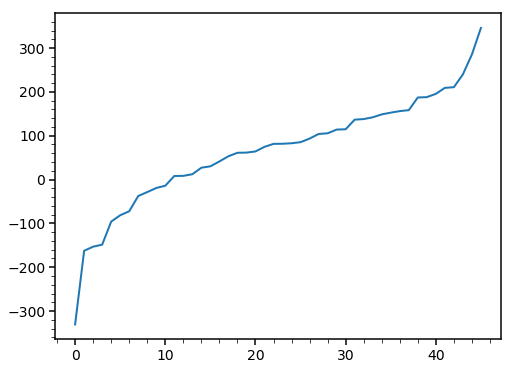

In [159]:
plt.plot(vz[vz.argsort()])

In [153]:
name[name.argsort()]

for ni,n in enumerate(name):
    if n in nameo:
        #print(n,nameo[nameo==n][0])
        print(n,edmb[ni],edmb2[nameo==n][0])
    else:
        pass
        #print(n,'MISSING')
    #print(n,nameo[nameo.argsort()][ni])


b'Antlia2' 0.0397 0.0374
b'Aquarius2' 0.1705 0.5835
b'Bootes1' 0.0367 0.097
b'Bootes2' 0.1891 0.3826
b'CanesVenatici1' 0.0466 0.0893
b'CanesVenatici2' 0.1213 0.2001
b'Carina' 0.0114 0.0411
b'Carina2' 0.0331 0.0947
b'Carina3' 0.0935 0.1457
b'Columba1' 0.0962 0.278
b'ComaBerenices' 0.0515 0.1267
b'Crater2' 0.0236 0.0736
b'Draco' 0.0109 0.0134
b'Draco2' 0.1817 0.3024
b'Eridanus2' 0.0551 0.2708
b'Fornax' 0.0023 0.0386
b'Grus1' 0.1364 0.2036
b'Grus2' 0.069 0.1074
b'Hercules' 0.0666 0.1305
b'Horologium1' 0.0537 0.1154
b'Hydra2' 0.1163 0.4682
b'Hydrus1' 0.0327 0.0582
b'Leo1' 0.0799 0.0713
b'Leo2' 0.0655 0.0912
b'Leo4' 0.1354 0.4361
b'Leo5' 0.111 0.3934
b'Phoenix2' 0.0894 0.1355
b'Pisces2' 0.1215 0.5529
b'Reticulum2' 0.0317 0.0574
b'Reticulum3' 0.2277 0.3375
b'Sculptor' 0.0046 0.0397
b'Segue1' 0.2333 0.2159
b'Segue2' 0.0949 0.1278
b'Sextans1' 0.0198 0.0467
b'Triangulum2' 0.1226 0.2029
b'Tucana2' 0.0617 0.0839
b'Tucana3' 0.0321 0.0492
b'Tucana4' 0.1106 0.2459
b'Tucana5' 0.2278 0.3989
b'UrsaMajo

In [154]:
nameo.size

46

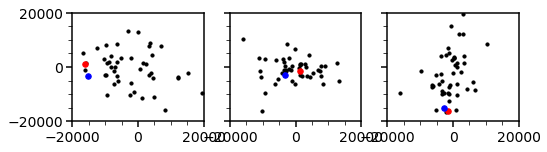

In [155]:
lmcx = -0.62
lmcvx = -39.47
lmcy = -42.11
lmcvy = -229.29
lmcz = -27.69
lmcvz = 230.24
lmcmom = [np.round(lmcy*lmcvz - lmcz*lmcvy),np.round(lmcz*lmcvx - lmcx*lmcvz),np.round(lmcx*lmcvy - lmcy*lmcvx)]


    
smcx = 16.35
smcvx = 7.77
smcy = -38.5
smcvy = -191.2 
smcz = -44.76
smcvz = 171.71
smcmom = [np.round(smcy*smcvz - smcz*smcvy),np.round(smcz*smcvx - smcx*smcvz),np.round(smcx*smcvy - smcy*smcvx)]




def compute_momentum(x,y,z,vx,vy,vz):
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)
    return Lx,Ly,Lz


Lx,Ly,Lz = compute_momentum(x,y,z,vx,vy,vz)

fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)




ax1.scatter(Lx,Ly,color='black',s=10.)
ax2.scatter(Ly,Lz,color='black',s=10.)
ax3.scatter(Lz,Lx,color='black',s=10.)

ax1.scatter(lmcmom[0],lmcmom[1],color='red',s=30.)
ax2.scatter(lmcmom[1],lmcmom[2],color='red',s=30.)
ax3.scatter(lmcmom[2],lmcmom[0],color='red',s=30.)


ax1.scatter(smcmom[0],smcmom[1],color='blue',s=30.)
ax2.scatter(smcmom[1],smcmom[2],color='blue',s=30.)
ax3.scatter(smcmom[2],smcmom[0],color='blue',s=30.)




for ax in [ax1,ax2,ax3]:
    ax.axis([-20000,20000,-20000,20000])

for ax in [ax2,ax3]:
    ax.set_yticklabels(())

[b'Horologium1' b'Carina' b'Phoenix2' b'Carina3' b'Eridanus2' b'Draco'
 b'UrsaMinor' b'Crater2' b'Hydrus1' b'Tucana4' b'Horologium2'
 b'Reticulum2' b'Columba1' b'Antlia2' b'Draco2' b'Grus2' b'Carina2'
 b'Hydra2' b'Pisces2' b'Tucana2']
[b'LMC' b'Horologium1' b'Carina' b'SMC' b'Phoenix2' b'Carina3' b'Draco'
 b'Hydrus1' b'UrsaMinor' b'Tucana4' b'Crater2' b'Reticulum2' b'Grus2'
 b'Draco2' b'Carina2' b'Fornax' b'Leo2' b'Tucana2' b'Antlia2' b'Willman1']


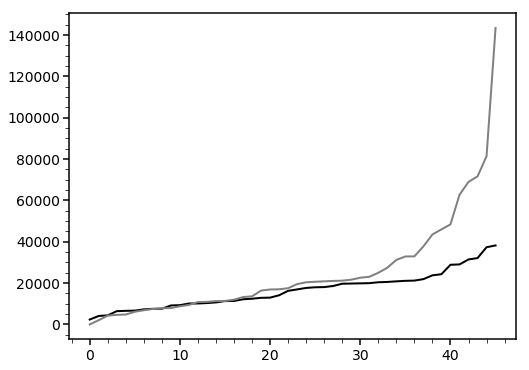

In [157]:
angmomdiff = np.sqrt((Lx-lmcmom[0])**2. + (Ly-lmcmom[1])**2. + (Lz-lmcmom[2])**2.)

plt.plot(angmomdiff[angmomdiff.argsort()],color='black')

print(name[angmomdiff.argsort()][0:20])

#angmomdiffo = np.sqrt((Lx-lmcmom[0])**2. + (Ly-lmcmom[1])**2. + (Lz-lmcmom[2])**2.)

plt.plot(angmomdiffo[angmomdiffo.argsort()],color='grey')

print(nameo[angmomdiffo.argsort()][0:20])

In [164]:
gname = b'Horologium1'
gname = b'Carina2'


x[name==gname][0],y[name==gname][0],z[name==gname][0],\
vx[name==gname][0],vy[name==gname][0],vz[name==gname][0]

(-8.35, -34.54, -10.62, 122.5, -298.93, 148.71)